In [1]:
import gym
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
env = gym.make('CartPole-v0')
env.seed(1234)
np.random.seed(1234)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

In [4]:
class QNetwork(nn.Module):
    def __init__(self, gamma=0.99, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, batch_size=20,
                 name='QNetwork'):
        nn.Module.__init__(self)
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

In [5]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]
    
    def length(self):
        return len(self.buffer)

In [6]:
train_episodes = 300          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

action_size = 2

# Exploration parameters
explore_start = 0.2            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 16               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 200000            # memory capacity
batch_size = 512                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [7]:
mainQN = QNetwork(name='main', hidden_size=hidden_size, gamma=gamma, learning_rate=learning_rate,batch_size=batch_size)

In [8]:
env.reset()
values = []
for i in range(100000):
    state, reward, done, _ = env.step(env.action_space.sample())
    values.append(state)
    if done:
        env.reset()

values_array = np.array(values)
means = values_array.mean(axis=0)
stds = values_array.std(axis=0)
print(means)
print(stds)

corr_matrix = np.corrcoef(((values_array-means)/stds).T)
print(corr_matrix)
eigen_values,eigen_vectors = np.linalg.eig(corr_matrix)
print(eigen_values)
print(eigen_vectors)

[ 0.0004358  -0.00099804 -0.00033619 -0.00033682]
[0.08951514 0.56175655 0.10311954 0.85250267]
[[ 1.          0.61846526 -0.58441522 -0.55432807]
 [ 0.61846526  1.         -0.52876887 -0.93836339]
 [-0.58441522 -0.52876887  1.          0.73222322]
 [-0.55432807 -0.93836339  0.73222322  1.        ]]
[2.99228063 0.00969851 0.53979171 0.45822915]
[[ 0.45287512  0.15927044 -0.64016511  0.59977137]
 [ 0.52312323 -0.61946411  0.50041959  0.30362235]
 [-0.47236106  0.28969475  0.41434422  0.7219909 ]
 [-0.54600481 -0.71202113 -0.40998504  0.16375872]]


In [9]:
def make_state(observation, means, stds, eigen_vectors, eigen_values):
    # return np.dot((np.array(observation) - means)/stds, eigen_vectors.T)/eigen_values
    return (np.array(observation) - means)/stds

In [10]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
observation, reward, done, _ = env.step(env.action_space.sample())
state = make_state(observation, means, stds, eigen_vectors, eigen_values)

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length - 1):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_observation, reward, done, _ = env.step(action)
    next_state = make_state(next_observation, means, stds, eigen_vectors, eigen_values)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, 0, next_state, done))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        observation, reward, done, _ = env.step(env.action_space.sample())
        state = make_state(observation, means, stds, eigen_vectors, eigen_values)
    else:
        # Add experience to memory
        memory.add((state, action, 0, next_state, done))
        state = next_state

In [11]:
# Now train with experiences
#saver = tf.train.Saver()
rewards_list = []
step = 0
opt = optim.Adam(mainQN.parameters(), learning_rate)

outputs = np.empty([1,6])

count_stop = 0
for ep in range(1, train_episodes):
    total_reward = 0
    t = 0
    # Start new episode
    env.reset()
    # Take one random step to get the pole and cart moving
    observation, reward, done, _ = env.step(env.action_space.sample())
    state = make_state(observation, means, stds, eigen_vectors, eigen_values)
            
    for t in range(max_steps):
        step += 1

        # Explore or Exploit
        explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
        if explore_p > np.random.rand():
            # Make a random action
            action = env.action_space.sample()
        else:
            # Get action from Q-network
            Qs = mainQN(Variable(torch.FloatTensor(state))).data.numpy()
            action = np.argmax(Qs)
            
        result = np.hstack((state, mainQN(Variable(torch.FloatTensor(state))).data.numpy()))
        outputs = np.vstack((outputs, result))

        # Take action, get new state and reward
        next_observation, reward, done, _ = env.step(action)
        next_state = make_state(next_observation, means, stds, eigen_vectors, eigen_values)

        total_reward += reward
        
        # Add experience to memory
        memory.add((state, action, 0, next_state, done))
        
        state = next_state

        # Sample mini-batch from memory
        batch = memory.sample(batch_size)
        states = np.array([each[0] for each in batch])
        ### ポイント！！！
        # actionはスカラーなのでベクトルにする
        # actionsはベクトルでなく、statesと同じ行列
        actions = np.array([[each[1]] for each in batch])
        ### ポイント終わり
        rewards = np.array([each[2] for each in batch])
        next_states = np.array([each[3] for each in batch])
        dones = np.array([each[4] for each in batch])

        # Train network
        non_final_mask = torch.tensor(tuple(map(lambda s: s==False, dones)), dtype=torch.uint8)
        # 終端状態のQ値はその後の報酬が存在しないためゼロとする
        target_maxQs = torch.zeros(batch_size)
        target_maxQs[non_final_mask] = mainQN(Variable(torch.FloatTensor(next_states)[non_final_mask])).max(1)[0].detach()

        #tutorial way
        targets = (torch.FloatTensor(rewards) + gamma * target_maxQs).unsqueeze(1)

        current_q_values = mainQN(Variable(torch.FloatTensor(states))).gather(1, torch.LongTensor(actions))
        loss = torch.nn.SmoothL1Loss()(current_q_values, targets)
        # backpropagation of loss to NN
        # 勾配を初期化
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if done:
            # the episode ends so no next state
            print('Episode: {}'.format(ep),
                  'Total reward: {}'.format(total_reward),
                  'Training loss: {:.4f}'.format(loss.data.numpy()),
                  'Explore P: {:.4f}'.format(explore_p))
            rewards_list.append((ep, total_reward))
            break
df = pd.DataFrame(outputs)
df.to_csv('result.csv')

Episode: 1 Total reward: 8.0 Training loss: 0.0120 Explore P: 0.1998
Episode: 2 Total reward: 10.0 Training loss: 0.0103 Explore P: 0.1997
Episode: 3 Total reward: 9.0 Training loss: 0.0107 Explore P: 0.1995
Episode: 4 Total reward: 11.0 Training loss: 0.0090 Explore P: 0.1993
Episode: 5 Total reward: 9.0 Training loss: 0.0100 Explore P: 0.1991
Episode: 6 Total reward: 11.0 Training loss: 0.0082 Explore P: 0.1989
Episode: 7 Total reward: 12.0 Training loss: 0.0081 Explore P: 0.1987
Episode: 8 Total reward: 10.0 Training loss: 0.0075 Explore P: 0.1985
Episode: 9 Total reward: 10.0 Training loss: 0.0060 Explore P: 0.1983
Episode: 10 Total reward: 10.0 Training loss: 0.0061 Explore P: 0.1981
Episode: 11 Total reward: 10.0 Training loss: 0.0057 Explore P: 0.1979
Episode: 12 Total reward: 14.0 Training loss: 0.0042 Explore P: 0.1977
Episode: 13 Total reward: 9.0 Training loss: 0.0042 Explore P: 0.1975
Episode: 14 Total reward: 8.0 Training loss: 0.0037 Explore P: 0.1973
Episode: 15 Total re

Episode: 117 Total reward: 52.0 Training loss: 0.0000 Explore P: 0.1166
Episode: 118 Total reward: 55.0 Training loss: 0.0000 Explore P: 0.1160
Episode: 119 Total reward: 99.0 Training loss: 0.0000 Explore P: 0.1150
Episode: 120 Total reward: 95.0 Training loss: 0.0000 Explore P: 0.1140
Episode: 121 Total reward: 143.0 Training loss: 0.0000 Explore P: 0.1125
Episode: 122 Total reward: 104.0 Training loss: 0.0000 Explore P: 0.1114
Episode: 123 Total reward: 149.0 Training loss: 0.0000 Explore P: 0.1099
Episode: 124 Total reward: 84.0 Training loss: 0.0000 Explore P: 0.1091
Episode: 125 Total reward: 57.0 Training loss: 0.0000 Explore P: 0.1085
Episode: 126 Total reward: 45.0 Training loss: 0.0000 Explore P: 0.1081
Episode: 127 Total reward: 125.0 Training loss: 0.0000 Explore P: 0.1069
Episode: 128 Total reward: 199.0 Training loss: 0.0000 Explore P: 0.1050
Episode: 129 Total reward: 170.0 Training loss: 0.0000 Explore P: 0.1034
Episode: 130 Total reward: 168.0 Training loss: 0.0000 Exp

Episode: 231 Total reward: 10.0 Training loss: 0.0188 Explore P: 0.0292
Episode: 232 Total reward: 11.0 Training loss: 0.0312 Explore P: 0.0292
Episode: 233 Total reward: 10.0 Training loss: 0.0085 Explore P: 0.0292
Episode: 234 Total reward: 9.0 Training loss: 0.0315 Explore P: 0.0292
Episode: 235 Total reward: 10.0 Training loss: 0.0037 Explore P: 0.0292
Episode: 236 Total reward: 9.0 Training loss: 0.0273 Explore P: 0.0291
Episode: 237 Total reward: 11.0 Training loss: 0.0281 Explore P: 0.0291
Episode: 238 Total reward: 7.0 Training loss: 0.0493 Explore P: 0.0291
Episode: 239 Total reward: 11.0 Training loss: 0.0462 Explore P: 0.0291
Episode: 240 Total reward: 12.0 Training loss: 0.0139 Explore P: 0.0291
Episode: 241 Total reward: 10.0 Training loss: 0.0947 Explore P: 0.0290
Episode: 242 Total reward: 11.0 Training loss: 0.0368 Explore P: 0.0290
Episode: 243 Total reward: 12.0 Training loss: 0.0146 Explore P: 0.0290
Episode: 244 Total reward: 9.0 Training loss: 0.0517 Explore P: 0.0

Text(0, 0.5, 'Total Reward')

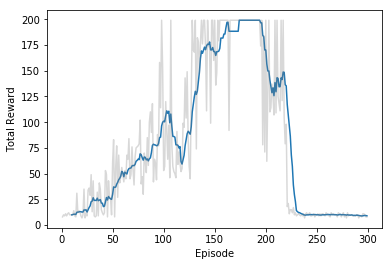

In [12]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')